prepare data







In [1]:
import gdown
url="https://drive.google.com/u/1/uc?id=1s9kUzhHCF3rbmXJnR3whEtgINSBe6Nbi&export=download"
output="final.rar"
gdown.download(url,output,quiet=False)

Downloading...
From: https://drive.google.com/u/1/uc?id=1s9kUzhHCF3rbmXJnR3whEtgINSBe6Nbi&export=download
To: /content/final.rar
17.8MB [00:00, 39.8MB/s]


'final.rar'

In [2]:
!pip install rarfile

In [3]:
import os
import rarfile
 
rar = rarfile.RarFile('final.rar') 
print (rar.namelist())
rar.extractall()
rar.close()

['image final project/0/CT/0.jpg', 'image final project/0/CT/1.jpg', 'image final project/0/CT/10.jpg', 'image final project/0/CT/11.jpg', 'image final project/0/CT/12.jpg', 'image final project/0/CT/13.jpg', 'image final project/0/CT/14.jpg', 'image final project/0/CT/15.jpg', 'image final project/0/CT/16.jpg', 'image final project/0/CT/17.jpg', 'image final project/0/CT/18.jpg', 'image final project/0/CT/19.jpg', 'image final project/0/CT/2.jpg', 'image final project/0/CT/3.jpg', 'image final project/0/CT/4.jpg', 'image final project/0/CT/5.jpg', 'image final project/0/CT/6.jpg', 'image final project/0/CT/7.jpg', 'image final project/0/CT/8.jpg', 'image final project/0/CT/9.jpg', 'image final project/0/FT/0.jpg', 'image final project/0/FT/1.jpg', 'image final project/0/FT/10.jpg', 'image final project/0/FT/11.jpg', 'image final project/0/FT/12.jpg', 'image final project/0/FT/13.jpg', 'image final project/0/FT/14.jpg', 'image final project/0/FT/15.jpg', 'image final project/0/FT/16.jp

In [4]:
!mv image\ final\ project image_final_project #change name 

將資料路徑保存到list 

In [5]:
input_dir='image_final_project/'
target_dir='image_final_project/'
img_size = (512, 512)
num_classes = 1  #這是什麼?
batch_size = 4
input_img_paths=[]
target1_img_paths=[]
target2_img_paths=[]
target3_img_paths=[]
target=['MN','CT','FT']
for i in range(10):
  train_input_dir=input_dir+str(i)+'/'+'T1'
  temp_input_img_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".jpg")
    ]
  )
  for t in target:
    target_input_dir=input_dir+str(i)+'/'+t
    temp_target_img_paths = sorted(
      [
          os.path.join(target_input_dir, fname)
          for fname in os.listdir(target_input_dir)
          if fname.endswith(".jpg")
      ]
    )
    if t=='MN':
      target1_img_paths.extend(temp_target_img_paths)
    elif t=='CT':
      target2_img_paths.extend(temp_target_img_paths)
    else:
      target3_img_paths.extend(temp_target_img_paths)

  input_img_paths.extend(temp_input_img_paths)
print("Number of samples:", len(input_img_paths))
print("Number of tatrget:", len(target1_img_paths))


Number of samples: 207
Number of tatrget: 207


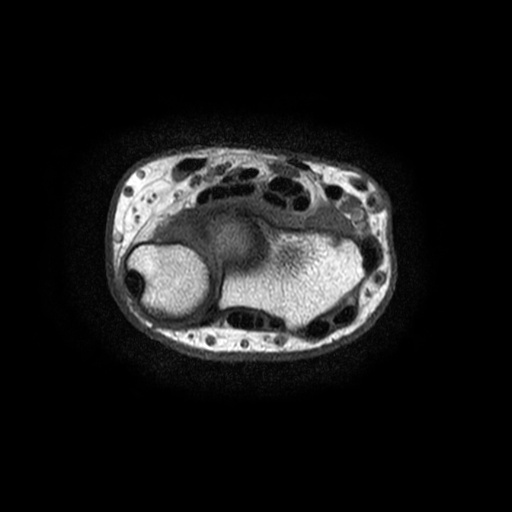

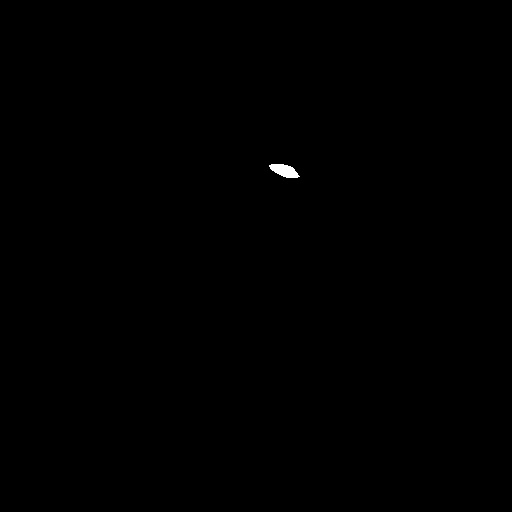

In [6]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
 
# Display input image #7
display(Image(filename=input_img_paths[9]))
 
# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target1_img_paths[9]))
display(img)

In [7]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
 
class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""
 
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
 
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
 
    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        y=(y/255)
        
        return x, y

In [8]:
from tensorflow.keras import layers
 
 
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
 
    ### [First half of the network: downsampling inputs] ###
 
    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
 
    previous_block_activation = x  # Set aside residual
 
    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
 
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
 
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
 
        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
 
    ### [Second half of the network: upsampling inputs] ###
 
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
 
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
 
        x = layers.UpSampling2D(2)(x)
 
        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
 
    # Add a per-pixel classification layer
    #outputs = layers.Conv2D(num_classes, 1, activation="softmax", padding="same")(x) #multi class
    outputs = layers.Conv2D(num_classes, 1, activation="sigmoid", padding="same")(x)  #binary
    # Define the model
    model = keras.Model(inputs, outputs)
    return model
 
 
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
 
# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
import random

# Split our img paths into a training and a validation set
val_samples = 203
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target1_img_paths)
train_input_img_paths = input_img_paths[:val_samples]
train_target1_img_paths = target1_img_paths[:val_samples]
val_input_img_paths = input_img_paths[val_samples:]
val_target1_img_paths = target1_img_paths[val_samples:]

train_target2_img_paths = target2_img_paths[:val_samples]
val_target2_img_paths = target2_img_paths[val_samples:]


train_target3_img_paths = target3_img_paths[:val_samples]
val_target3_img_paths = target3_img_paths[val_samples:]

# Instantiate data Sequences for each split
train_gen1 = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target1_img_paths
)
val_gen1 = OxfordPets(batch_size, img_size, val_input_img_paths, val_target1_img_paths)

train_gen2 = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target2_img_paths
)
val_gen2 = OxfordPets(batch_size, img_size, val_input_img_paths, val_target2_img_paths)

train_gen3 = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target3_img_paths
)
val_gen3 = OxfordPets(batch_size, img_size, val_input_img_paths, val_target3_img_paths)

訓練model-1用來找出mn神經

In [ ]:

# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
#model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy") #多類
model.compile(optimizer="rmsprop", loss="binary_crossentropy") #二元
callbacks = [
    keras.callbacks.ModelCheckpoint("MN_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 100
history=model.fit(train_gen1, epochs=epochs, validation_data=val_gen1, callbacks=callbacks)


Epoch 1/100
50/50 [==============================] - 25s 275ms/step - loss: 0.1905 - val_loss: 0.0113
Epoch 2/100
50/50 [==============================] - 13s 265ms/step - loss: 0.0250 - val_loss: 0.0098
Epoch 3/100
40/50 [=======================>......] - ETA: 2s - loss: 0.0138

訓練model-2找出ct

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
#model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy") #多類
#model.compile(optimizer="rmsprop", loss="binary_crossentropy") #二元
#callbacks = [
    #keras.callbacks.ModelCheckpoint("CT_segmentation.h5", save_best_only=True)
#]

# Train the model, doing validation at the end of each epoch.
#epochs = 100
#history2=model.fit(train_gen2, epochs=epochs, validation_data=val_gen2, callbacks=callbacks)

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
#model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy") #多類
#model.compile(optimizer="rmsprop", loss="binary_crossentropy") #二元
#callbacks = [
    #keras.callbacks.ModelCheckpoint("FT_segmentation.h5", save_best_only=True)
#]

# Train the model, doing validation at the end of each epoch.
#epochs = 100
#history3=model.fit(train_gen3, epochs=epochs, validation_data=val_gen3, callbacks=callbacks)

In [ ]:
import matplotlib.pyplot as plt
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs=range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('result')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# 新增區段

製作predict data的batch


In [ ]:
class test_predict2(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""
 
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
 
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
 
    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths
        batch_target_img_paths = self.target_img_paths
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        y=(y/255)
        
        return x, y

In [ ]:
# Generate predictions for all images in the validation set

#val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
#val_preds = model.predict(val_gen)

test1= test_predict2(1,img_size,['image_final_project/0/T1/0.jpg'],['image_final_project/0/MN/0.jpg'])


#model1 = keras.models.load_model('MN_segmentation.h5')
pred1 = model.predict(test1)

#model.save('CT_segmentation.h5')
#model2 = keras.models.load_model('CT_segmentation.h5')
#pred2 = model2.predict(test1)
#model.save('FT_segmentation.h5')
#model3 = keras.models.load_model('FT_segmentation.h5')
#pred3 = model3.predict(test1)


def return_mask(pred):
    """Quick utility to display a model's prediction."""
    #mask = np.argmax(val_preds[i], axis=-1)
    mask = (pred>0.5).astype('int')*255
    mask=mask.squeeze()
    mask = np.expand_dims(mask, axis=-1)
    
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    return img


# Display results for validation image #10
#i = 3
#print(val_input_img_paths)
# Display input image
#display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
#img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
#print(val_target_img_paths[i])
#display(img)

# Display mask predicted by our model
display(return_mask(pred1))  # Note that the model only sees inputs at 150x150.
#display(return_mask(pred2)) 
#display(return_mask(pred3)) 


In [ ]:
model.save('mn.h5')

將畫出來的mask描出邊界


In [ ]:
from google.colab.patches import cv2_imshow
import cv2
label1=return_mask(pred1)
label1.save('test1.jpg')
label2=return_mask(pred2)
label2.save('test2.jpg')
label3=return_mask(pred3)
label3.save('test3.jpg')
timage= cv2.imread('image_final_project/0/T1/0.jpg', cv2.IMREAD_GRAYSCALE) #background
timage=cv2.cvtColor(timage, cv2.COLOR_GRAY2BGR)
for i in range(3):
  file_Name='test'+str(i+1)+'.jpg'
  image = cv2.imread(file_Name)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (11, 11), 0)
  canny = cv2.Canny(blurred, 30, 150)
  contours, hierarchy= cv2.findContours(canny.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  if i==0 :
    cv2.drawContours(timage, contours, -1, (255,0,0), 2)
  elif i==1:
    cv2.drawContours(timage, contours, -1, (0,255,0), 2)
  else:
    cv2.drawContours(timage, contours, -1, (0,0,255), 2)
  cv2_imshow(image)
  #timage=cv2.add(timage,image)
cv2_imshow(timage)

